In [7]:
!pip install pykalman

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from math import sqrt

from pykalman import KalmanFilter
from sklearn.linear_model import Ridge
from statsmodels.tsa.stattools import adfuller


In [10]:
import yfinance as yf
import pandas as pd

# Download data
msft_raw = yf.download("MSFT", start="2015-01-01", end="2024-01-01")

if isinstance(msft_raw.columns, pd.MultiIndex):
    # Select MSFT ticker level
    msft_raw = msft_raw.xs('MSFT', level=1, axis=1)

msft = msft_raw[['Close']].copy()
msft.rename(columns={'Close': 'price'}, inplace=True)

msft.dropna(inplace=True)

print(msft.head())
print(msft.columns)


/tmp/ipython-input-2432868883.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft_raw = yf.download("MSFT", start="2015-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price           price
Date                 
2015-01-02  39.858452
2015-01-05  39.491920
2015-01-06  38.912289
2015-01-07  39.406670
2015-01-08  40.565948
Index(['price'], dtype='object', name='Price')


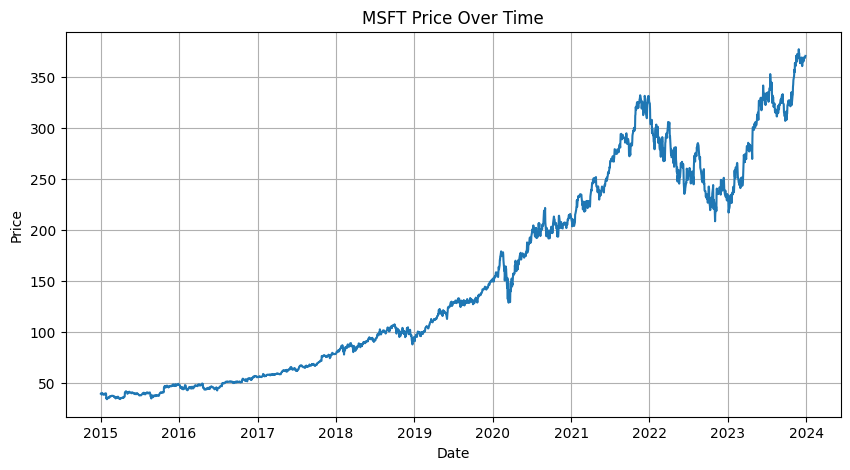

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(msft.index, msft['price'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("MSFT Price Over Time")
plt.grid(True)
plt.show()


In [12]:
import numpy as np
import pandas as pd

msft['log_return'] = np.log(msft['price'] / msft['price'].shift(1))
msft['lag_return'] = msft['log_return'].shift(1)

msft['ma_5']  = msft['price'].rolling(5).mean()
msft['ma_20'] = msft['price'].rolling(20).mean()
msft['ma_60'] = msft['price'].rolling(60).mean()

msft['roc_5'] = msft['price'].pct_change(5)

msft['ma_momentum'] = msft['ma_5'] - msft['ma_20']

msft['vol_20'] = msft['log_return'].rolling(20).std()

if 'Volume' in msft.columns:
    msft['vol_ma_20'] = msft['Volume'].rolling(20).mean()
    msft['volume_change'] = msft['Volume'].pct_change()

msft['price_ratio'] = msft['price'].shift(-1) / msft['price']
msft['current_ratio'] = msft['price'] / msft['price'].shift(1)

msft['vol_ratio'] = msft['vol_20'] / msft['vol_20'].rolling(60).mean()

msft['trend_60'] = msft['price'] / msft['ma_60'] - 1

msft['zscore_price'] = (
    msft['price'] - msft['ma_20']
) / msft['price'].rolling(20).std()

msft.dropna(inplace=True)

print(msft[['price', 'price_ratio']].head())

print(msft.head())
print(msft.columns)


Price           price  price_ratio
Date                              
2015-04-28  42.202438     0.997966
2015-04-29  42.116608     0.991439
2015-04-30  41.756039     1.000411
2015-05-01  41.773205     0.991369
2015-05-04  41.412643     0.986733
Price           price  log_return  lag_return       ma_5      ma_20  \
Date                                                                  
2015-04-28  42.202438    0.023254    0.003337  39.728326  36.732263   
2015-04-29  42.116608   -0.002036    0.023254  40.770514  37.092821   
2015-04-30  41.756039   -0.008598   -0.002036  41.680494  37.432775   
2015-05-01  41.773205    0.000411   -0.008598  41.816132  37.792046   
2015-05-04  41.412643   -0.008669    0.000411  41.852187  38.079205   

Price           ma_60     roc_5  ma_momentum    vol_20  price_ratio  \
Date                                                                  
2015-04-28  36.592258  0.152908     2.996064  0.024522     0.997966   
2015-04-29  36.707747  0.141196     3.677693

In [13]:
from statsmodels.tsa.stattools import adfuller

def run_adf(series, name):

    result = adfuller(series.dropna())

    print(f"ADF Test on {name}")
    print(f"p-value       : {result[1]:.4f}")

    if result[1] < 0.05:
        print("Conclusion    : Series is stationary (Reject H0)")
    else:
        print("Conclusion    : Series is non-stationary (Fail to Reject H0)")

    print("-" * 50)

run_adf(msft['price'], "MSFT Price")
run_adf(msft['price_ratio'], "MSFT Price ratio")


ADF Test on MSFT Price
p-value       : 0.9889
Conclusion    : Series is non-stationary (Fail to Reject H0)
--------------------------------------------------
ADF Test on MSFT Price ratio
p-value       : 0.0000
Conclusion    : Series is stationary (Reject H0)
--------------------------------------------------


In [14]:
from pykalman import KalmanFilter
import numpy as np

def KalmanFilterTrend(price):
    n = len(price)


    t = np.arange(n)

    obs_mat = np.vstack([np.ones(n), t]).T[:, np.newaxis]


    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)

    obs_cov = np.var(price.values) * 0.5


    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=[price.iloc[0], 0],
        initial_state_covariance=np.eye(2),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=obs_cov,
        transition_covariance=trans_cov
    )

    state_means, _ = kf.filter(price.values)

    fair_value = state_means[:, 0]
    trend = state_means[:, 1]

    return fair_value, trend


msft['fair_value'], msft['trend'] = KalmanFilterTrend(msft['price'])
msft['deviation'] = msft['price'] - msft['fair_value']


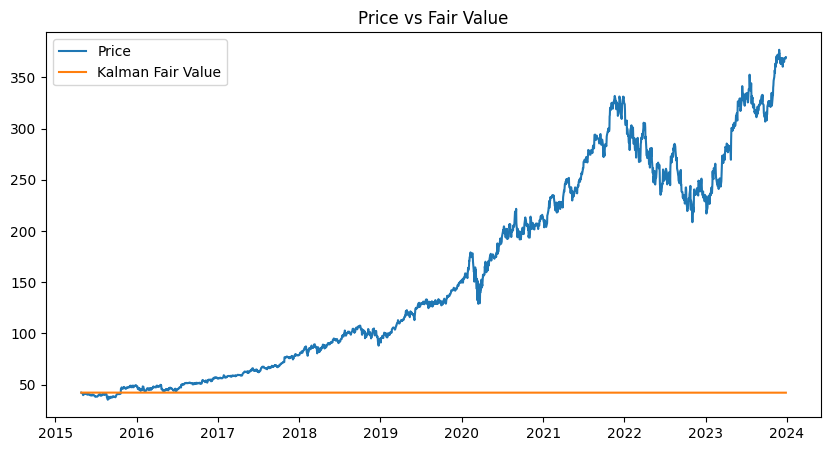

In [15]:
plt.figure(figsize=(10,5))
plt.plot(msft['price'], label='Price')
plt.plot(msft['fair_value'], label='Kalman Fair Value')
plt.legend()
plt.title("Price vs Fair Value")
plt.show()

In [34]:
features = [
    'lag_return',
    'roc_5',
    'ma_momentum',
    'current_ratio',
    'vol_20',
    'vol_ratio',
    'trend_60',
    'zscore_price'
]
X = msft[features].values
y = msft['price'].values

kf_reg = KalmanFilter(
    transition_matrices=np.eye(len(features)),
    observation_matrices=X[:, np.newaxis, :],
    initial_state_mean=np.zeros(len(features)),
    initial_state_covariance=np.eye(len(features)),
    transition_covariance=0.001 * np.eye(len(features)),
    observation_covariance=0.01
)

state_means, _ = kf_reg.filter(y)


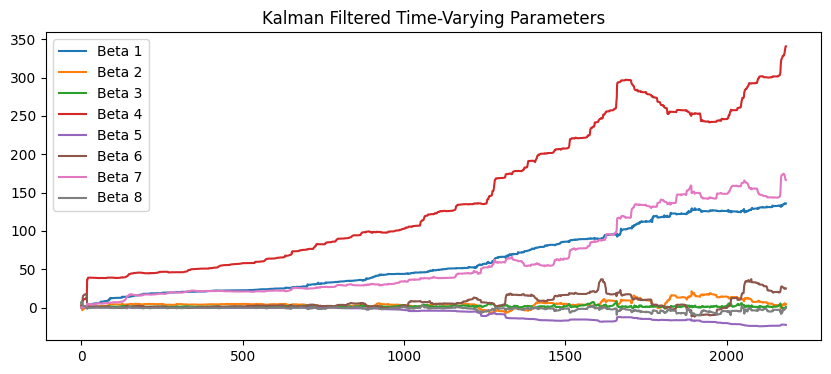

In [35]:
plt.figure(figsize=(10,4))

for i in range(state_means.shape[1]):
    plt.plot(state_means[:, i], label=f'Beta {i+1}')

plt.title("Kalman Filtered Time-Varying Parameters")
plt.legend()
plt.show()


In [36]:
features = ['lag_return', 'current_ratio','trend_60']
X = msft[features].values
y = msft['price'].values

kf_reg = KalmanFilter(
    transition_matrices=np.eye(len(features)),
    observation_matrices=X[:, np.newaxis, :],
    initial_state_mean=np.zeros(len(features)),
    initial_state_covariance=np.eye(len(features)),
    transition_covariance=0.001 * np.eye(len(features)),
    observation_covariance=0.01
)

state_means, _ = kf_reg.filter(y)


In [37]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = state_means[:-1]
y_target = y[1:]


split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y_target[:split_idx], y_target[split_idx:]

print("Train size:", len(X_train))
print("Test size :", len(X_test))

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=5,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse

    print(f"{name} RMSE: {rmse:.6f}")

best_model_name = min(results, key=results.get)
print("\nBest Model:", best_model_name)
print("Best RMSE :", results[best_model_name])

best_model = models[best_model_name]

msft_test = msft.iloc[-len(y_test):].copy()
msft_test['predicted_ratio'] = best_model.predict(X_test) / msft_test['price']

print(msft_test[['price', 'predicted_ratio']].head())
print(msft_test[['price', 'predicted_ratio']].tail())

msft['predicted_ratio'] = best_model.predict(state_means) / msft['price']
msft['predicted_price'] = best_model.predict(state_means)

Train size: 1746
Test size : 437
Linear Regression RMSE: 14.577457
Ridge Regression RMSE: 14.577452
Random Forest RMSE: 27.589538

Best Model: Ridge Regression
Best RMSE : 14.577451937852324
Price            price  predicted_ratio
Date                                   
2022-04-04  305.389771         0.969619
2022-04-05  301.424194         0.980104
2022-04-06  290.390259         1.021139
2022-04-07  292.203461         1.024300
2022-04-08  287.937256         1.033746
Price            price  predicted_ratio
Date                                   
2023-12-21  368.052399         0.979703
2023-12-22  369.077087         0.977258
2023-12-26  369.155975         0.978540
2023-12-27  368.574646         0.982843
2023-12-28  369.766846         0.982650


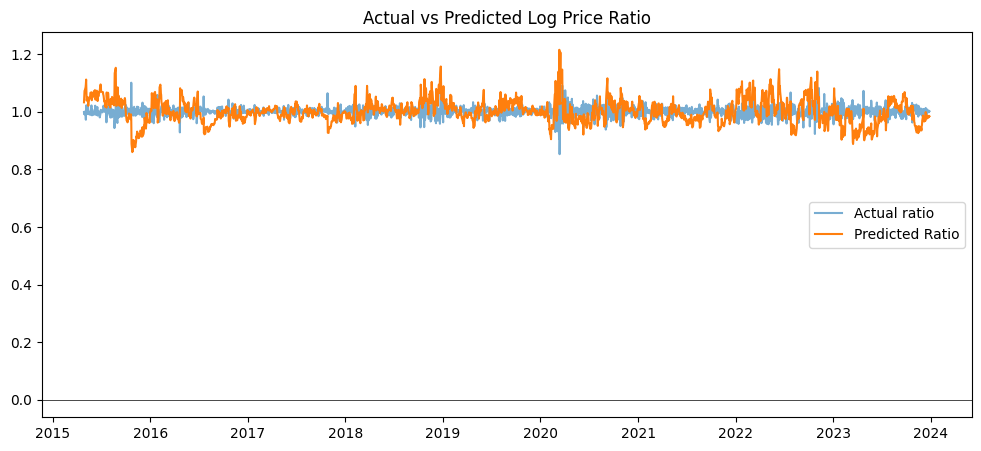

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(msft.index, msft['price_ratio'], label='Actual ratio', alpha=0.6)
plt.plot(msft.index, msft['predicted_ratio'], label='Predicted Ratio', alpha=1)
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.title('Actual vs Predicted Log Price Ratio')
plt.show()

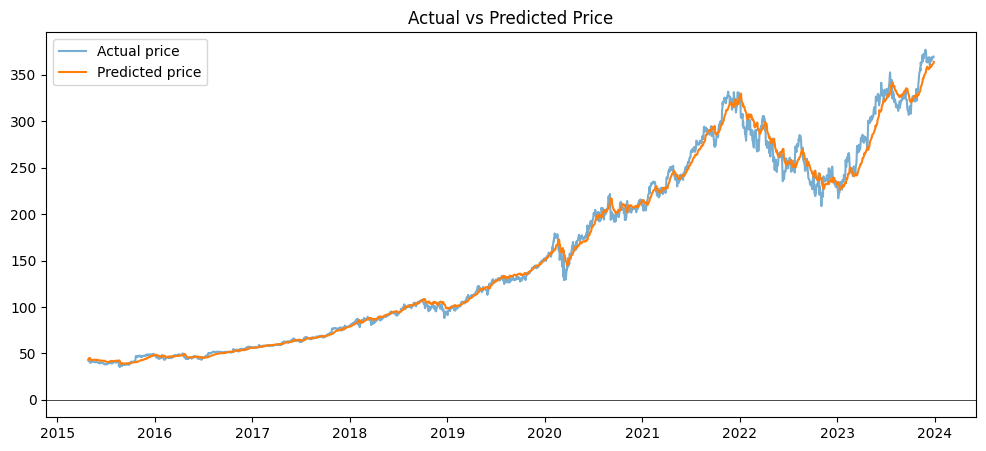

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(msft.index, msft['price'].shift(-1), label='Actual price', alpha=0.6)
plt.plot(msft.index, msft['predicted_price'], label='Predicted price', alpha=1)
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.title('Actual vs Predicted Price')
plt.show()

In [40]:
threshold = 0.02546
msft['signal'] = 0

msft.loc[
    msft['predicted_ratio'] > msft['current_ratio'] + threshold,
    'signal'
] = 1

msft.loc[
    msft['predicted_ratio'] < msft['current_ratio'] - threshold,
    'signal'
] = -1


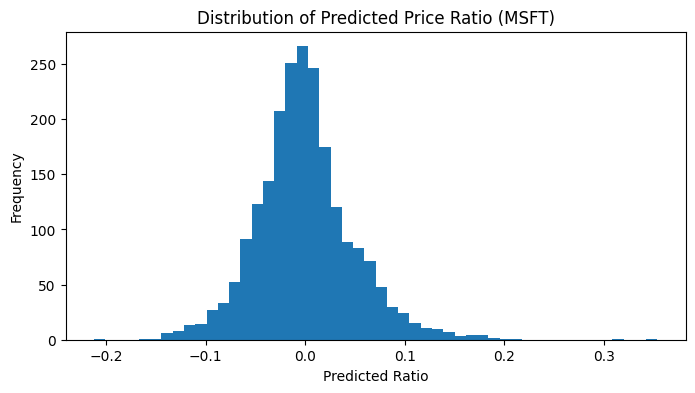

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(msft['predicted_ratio']-msft['current_ratio'], bins=50)
plt.title("Distribution of Predicted Price Ratio (MSFT)")
plt.xlabel("Predicted Ratio")
plt.ylabel("Frequency")
plt.show()


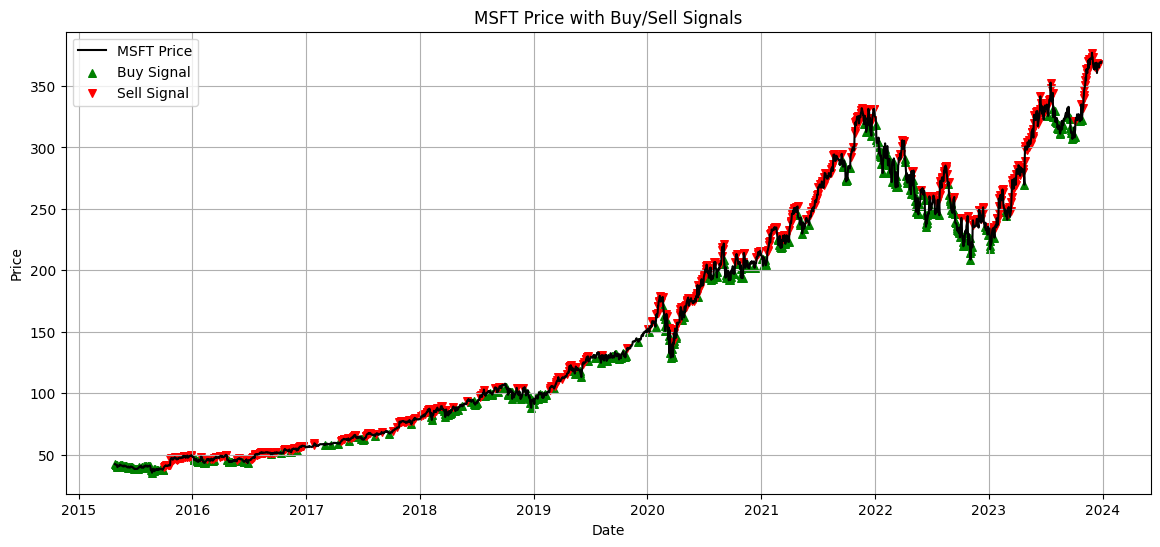

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Plot price
plt.plot(msft.index, msft['price'], label='MSFT Price', color='black')

# Buy signals
plt.scatter(
    msft.index[msft['signal'] == 1],
    msft['price'][msft['signal'] == 1],
    color='green',
    label='Buy Signal',
    marker='^',
    s=30
)

# Sell signals
plt.scatter(
    msft.index[msft['signal'] == -1],
    msft['price'][msft['signal'] == -1],
    color='red',
    label='Sell Signal',
    marker='v',
    s=30)

plt.title("MSFT Price with Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.show()


In [43]:
msft['position'] = msft['signal'].shift(1)
msft['position'] = msft['position'].fillna(0)
msft['returns'] = msft['price'].pct_change()
msft['strategy_returns'] = msft['position'] * msft['returns']
transaction_cost = 0.0005


msft['trade'] = msft['position'].diff().abs()

msft['strategy_returns'] -= msft['trade'] * transaction_cost

msft['cum_strategy'] = (1 + msft['strategy_returns']).cumprod()
msft['cum_buy_hold'] = (1 + msft['returns']).cumprod()

def sharpe_ratio(returns):
    returns = returns.dropna()
    if returns.std() == 0:
        return 0.0
    return (returns.mean() / returns.std()) * sqrt(252)
strategy_sharpe = sharpe_ratio(msft['strategy_returns'])
buyhold_sharpe = sharpe_ratio(msft['returns'])
def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()
strategy_mdd = max_drawdown(msft['cum_strategy'])
buyhold_mdd = max_drawdown(msft['cum_buy_hold'])
trade_returns = msft.loc[msft['trade'] > 0, 'strategy_returns']

wins = (trade_returns > 0).sum()
losses = (trade_returns < 0).sum()

win_loss_ratio = wins / losses if losses != 0 else np.nan

strategy_total_return = msft['cum_strategy'].iloc[-1] - 1
buyhold_total_return = msft['cum_buy_hold'].iloc[-1] - 1
msft['trade_id'] = (msft['position'].diff() != 0).cumsum()

trade_pnl = msft.groupby('trade_id')['strategy_returns'].sum()

trade_pnl = trade_pnl[trade_pnl != 0]

wins = (trade_pnl > 0).sum()
losses = (trade_pnl < 0).sum()

win_loss_ratio = wins / losses if losses != 0 else np.nan

In [44]:
print(f"Cumulative Return   : {strategy_total_return:.2%}")
print(f"Sharpe Ratio        : {strategy_sharpe:.2f}")
print(f"Maximum Drawdown    : {strategy_mdd:.2%}")
print(f"Win/Loss Ratio      : {win_loss_ratio:.2f}")

Cumulative Return   : 765.18%
Sharpe Ratio        : 1.22
Maximum Drawdown    : -24.01%
Win/Loss Ratio      : 0.56


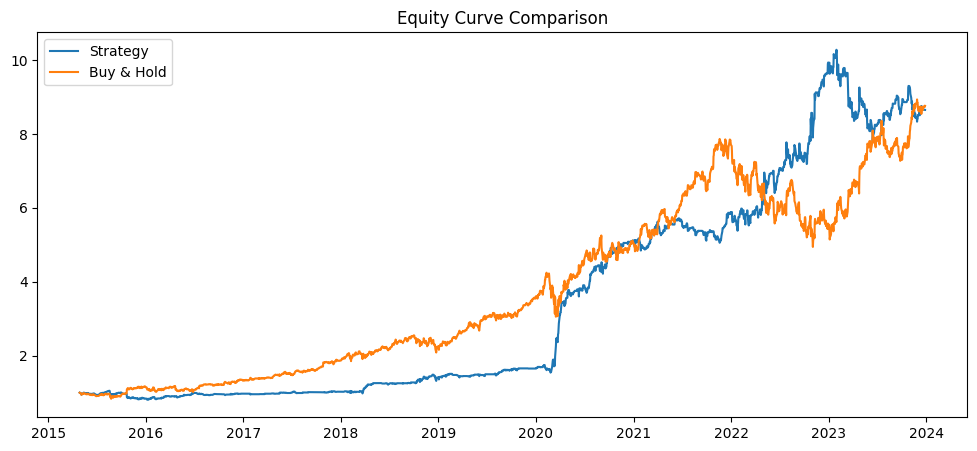

In [45]:
plt.figure(figsize=(12,5))
plt.plot(msft['cum_strategy'], label='Strategy')
plt.plot(msft['cum_buy_hold'], label='Buy & Hold')
plt.title("Equity Curve Comparison")
plt.legend()
plt.show()
